# Costa Rican Household Poverty Level Prediction
또 다른 Kaggle challenge에 온걸 환영한다. 코스타리카 가구 가난 수준 예측 공모전의 목적은 개인과 가정의 특성 모두를 사용하여 가정의 가난 레벨을 예측하기 위한 머신러닝 모델을 개발하는것이다. 이 "좋은 것을 위한 더이터 과학" 프로젝트는 사람들이 광고를 클릭하는 것보다 사회 적으로 더 유익한 일에 우리의 기술들을 투입할 기회를 제공한다.

이 노트북에서, 우리는 완벽한 머신러닝 솔류션을 천천히 소개할 것이다.  
1. 문제를 소개
2. Dataset에 EDA(Exploratory Data Analysis) 수행
3. Feature engineering
4. 여러 머신러닝 model을 시험
5. model selection
6. model을 최적화하기 위한 작업
7. model의 출력을 inspection & draw

이 노트북은 leaderboard의 상위에 오르지 못할 수도 있지만, 향후 머신 러닝 프로젝트를 위한 탄탄한 기반을 제공하기 위한 교육 도구로 사용된다. Kaggle 프로젝트는 우리에게 기계학습에 대해 많은 것을 알려줄 수 있지만, leaderboard의 상위에 도달하는데 사용되는 몇 가지 전략들은 모범 사례가 아니다. 따라서 여기서 우리는 매우 좋은 (비록 1위는 아니지만) 머신러닝 솔류션을 계속 구축할 것이다. Kaggle 프로젝트는 대회이지만, 대회를 가장한 "머신 러닝 교육"으로 가장 잘 묘사된다고 생각한다.

만약 너가 이 작업에 대한 후속 작업(follow-up) 원한다면, 나는 이 문제를 위한 [Featuretools](https://featuretools.alteryx.com/en/stable/#minute-quick-start)와 함께 [자동화된 특징 엔지니어링(Automated Feature Engineering)](https://www.kaggle.com/code/willkoehrsen/featuretools-for-good/notebook)을 사용한 커널을 포함한 추가 작업이 있다.(leaderboard 점수가 약간 더 높다.)(너가 나의 글쓰기 스타일과 설명이 맘에든다면, 나는 [Toward Data Science](https://williamkoehrsen.medium.com/)에 글을 올린다.)

## Problem and Data Explanation
이 competition의 data는 `train.csv`와 `test.csv`의 두가지 파일이 제공된다. training set은 9557개의 row와 143개의 columns를 가지고 tseting set은 23856개의 row와 142개의 column을 가진다. 각 row는 한 **개인**을 나타내며 각 column은 **개인 또는 개인의 가구를 위한 특성**이다. training set은 1~4 poverty level로 표현된 competition의 label인 Target column을 추가로 가지고 있다. 값 1은 가장 극심한 poverty이다.

이것은 **supervised multi-class classification 머신러닝 문제**이다.

- **Supervised**: training data에 label들이 함께 제공
- **Multi-class classification**: Label들은 4개의 클래스가 있는 이산 값

### objective
목표는 **가구 레벨**에서 빈곤을 예측하는 것이다. 우리는 개인 수준에 대한 데이터를 제공받으며 각 개인은 고유한 특징을 가지고 있지만 그들의 가정에 대한 정보도 가지고 있다. 이 task 위한 dataset을 만들려면, 각 가정에 대한 개별 데이터의 집계를 몇 가지 수행해야 한다. 게다가, 우리는 test set의 모든 개인에 대해 예측을 해야 하지만, "*가장만 채점에 사용된다*"는 것은 우리가 가구 단위로 poverty을 예측하기를 원한다는 것을 의미한다.

**Important note: training data에 한 가구의 모든 구성원이 동일한 label을 가져야 하지만, 동일한 가구의 개인이 서로 다른 label을 갖는 오류가 있다. 이러한 경우 각 가구의 가장에 대한 label을 사용하도록 하며, 이는 parentesco1 == 1.0인 행으로 식별할 수 있다.** 우리는 이 문제를 해결하는 방법에 대해서는 노트북에 설명한다.(더 많은 정보는 [competition main discussion](https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/discussion/61403)을 봐라.)

Target level
```
1 = extreme poverty 
2 = moderate poverty 
3 = vulnerable households 
4 = non vulnerable households
```

모든 143개의 columns에 대한 설명은 [competition documentation](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data) 확인할 수 있지만, 몇 가지 알아야할 사향은 다음과 같다.
- **id**: 각 개인의 고유 식별자, 이것은 우리가 사용하는 기능이 되어서는 안된다.
- **idhogar**: 각 가정의 고유 식별자, 이 variable은 특징이 아니지만, 한 가구의 모든 개인이 동일한 식별자를 가지므로 가구별로 개인을 그룹화하는데 사용된다.
- **parentesco1**: 이 사람이 가장인지 여부를 나타낸다.
- **Target**: label, 한 가구의 모든 구성원에 대해 동일해야 한다.

model을 만들 때, 우리는 *가장의 poverty level에 대한 라벨*을 각 가정에 부착하여 가구 단위로 교육할 것이다. raw data는 가정와 개인의 특징이 모두 혼합되어 있으며 개별데이터의 경우, 우리는 각 가정에 대해 이것을 합치는 방법을 알아야할 것이다. 일부 개인은 *가장이 없는 가정*에 속한다. 이것은 불행하게도 우리가 이 데이터를 훈련에 사용할 수 없다는 것을 의미한다.데이터에 대한 이러한 문제는 완벽히 **real-world** data의 전형적이고 이런 이유로 이 문제는 data science 작업에서 만나게 될 데이터 세트에 대한 훌륭한 준비이다.

### Metric
궁극적으로 우리는 가정의 정수범위 poverty level을 예측할 수 있는 머신러닝 model을 만들기를 원한다. 우리의 예측은 **Macro F1 Score**로 편가될 것이다. 너는 precision과 recall의 조화 평균인 이진 분류 문제에 대한 [standard F1 score](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)를 잘 알고 있을 것입니다.

$$F1=\frac{2}{\frac{1}{recall}+\frac{1}{precision}}=2⋅\frac{precision⋅recall}{precision+recall}$$

multi-class problems의 경우, 우리는 각 클래스의 F1 점수를 평균해야 합니다. macro F1 score는 label 불균형을 고려하지 않고 각 클래스에 대한 F1 score를 평균합니다.

$$Macro F1 = \frac{F1 Class 1 + F1 Class 2 + F1 Class 3 + F1 Class 4}{4}$$

다시 말해, 각 label의 발생 횟수는 macro(매크로)를 사용할 때 계산에 반영되지 않는다("weighted(가중치)" 점수를 사용할 때 반영된다).(차이에 대한 자세한 내용은 [Scikit-Learn Documentation for F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) 또는 이 [Stack Exchange 질문과 답변](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)을 참조해라.) 성능을 평가하려면, 다음 코드를 사용할 수 있다.
```python
from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro`)
```

이 문제의 경우, label이 불균형하므로 평가 메트릭에 매크로 평균을 사용하는 것이 조금 이상하지만, 이는 주최자가 내린 결정이지 변경할 수 있는 것은 아닙니다! 자신의 작업에서는 레이블 불균형을 인식하고 그에 따라 메트릭을 선택하려고 합니다.

## Roadmap
최종 목표는 가정의 poverty level을 예측할 수 있는 머신러닝 model이다. 그러나 모델링을 시작하기 전에 문제와 데이터를 이해하는 것이 중요하다. 또한, 우리는 "최고"로 하나를 선택하기 전에 수많은 모델을 평가하고 모델을 구축한 후에 예측을 조사하고자 한다. 따라서 로드맵은 다음과 같다.
1. 문제 이해(이미 거의 진행했다.)
2. 탐색적 데이터 분석(Exploratory Data Analysis, EDA)
3. 머신러닝을 위한 dataset 만드는 과정(Feature engineering)
4. 몇 가지 기본 머신러닝 model 비교
5. 좀 더 복잡한 머신러닝 modle 시도
6. 선택한 model 최적화
7. 문제의 맥락에서 model 예측 조사
8. 결론을 도출하고 다음 단계 제시

위에 제시된 단계는 반복적 의미한다. 한 번에 하나씩 살펴보겠지만, 이전 단계로 돌아가서 몇 가지 결정을 재검토할 수도 있다. 일반적으로 data science는 우리가 끊임없이 과거의 결정을 평가하고 개선을 하는 비 선형 관행이다. 특히, feature engineering, modeling 및 optimization은 우리가 처음 제대로 이해했는지 알 수 없기 때문에 자주 반복하는 단계이다.

# Getting Started
우리는 이 문제에 대해 꽤 잘 이해하고 있으므로, 탐색적 데이터 분석(EDA)과 feature engineering으로 넘어갈 것이다. EDA의 경우 우리는 feature engineering 및 modeling에 사용할 수 있는 흥미로운 이상 징후, 추세, 상관 관계 또는 패턴을 조사한다. 우리는 반드시 데이터를 양적으로(통계로) 그리고 시각적으로(수치로) 조사할 것이다.

데이터와 잠재적으로 유용한 관계를 잘 파악하면 feature engineering(머신 러닝 파이프라인의 가장 중요한 부분)을 수행하고 기준 model을 설정할 수 있다. 이렇게 하면 leaderboard의 맨 위에 오르지 못하지만, 이를 바탕으로 강력한 기반을 구축할 수 있다.

**Import**  
우리는 익숙한 data science libraries들(`Pandas`,`numpy`,`matplotlib`,`seaborn`)을 사용하고 궁국적으로 modeling을 위해 `sklearn`을 사용한다.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data and Look at Summary Information

In [6]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


130개의 정수 columns, 8개의 부동(숫자) columns 및 5개의 객체 columns이 있다.  
정수 columns은 아마도 Boolean variables(0 or 1) 또는 ordinal variables를 나타낸다.  
객체 column은 머신러닝 model에 직접 사용(fed)할 수 없기 때문에 문제가 될 수 있다.

train data보다 row(개인)가 더 많은 test data를 살펴보자. Target이 없기 때문에 columns이 하나 더 적다.

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


**Integer Columns**
정수 columns의 고유 값 분포를 보자. 각 column에 대해 우리는 고유 값을  세고 막대 그림에 결과를 보여준다.

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

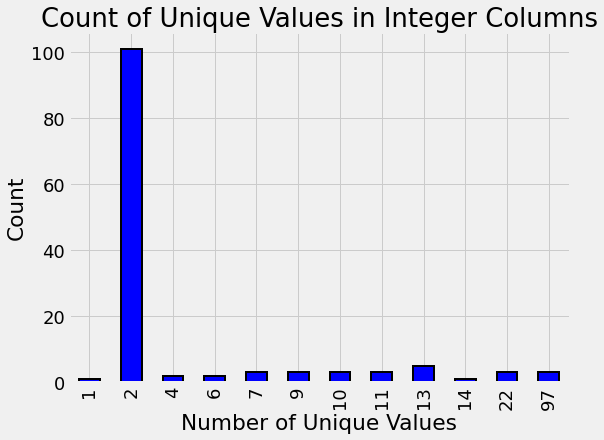

In [15]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8,6), 
                                                                             edgecolor = 'k', 
                                                                             linewidth = 2);
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')

두 개의 고유 값만 있는 columns은 Booleans(0 또는 1)을 나타낸다. 많은 경우, Boolean 정보는 이미 가정 level에 있다. 예를들어, `refrig` column은 가정에 냉장고(refrigerator) 유무를 말하고 있다. 이것은 가정 level에 있는 Boolean columns에서 feature를 만들 때, 우리는 이것들을 종합할 필요가 없을 것이다. 그러나 level에 있는 Bloolean columns들은 aggregate가 필요할 것이다.


**Float Columns**
또 다른 column type은 연속 변수(continuous variables)로 되어있는 floats이다. 우리는 모든 float columns의 분포를 보여주는 빠른 분포도(quick distribution)를 만들 수 있습니다. 우리는 `OrderedDict`를 poverty level의 색상에 매핑하기위해 사용한다. 왜냐하면 이것은 (일반 파이썬 딕셔너리와 달리) 키와 값이 지정된 순서대로 유지되기 때문이다.

다음 그래프는 `Target` 값에 따라 색상이 지정된 float columns의 분포를 보여준다. 이러한 그림을 통해, 우리는 가정 poverty level에 따라 variance 분포에 중요한 차이가 있는지 알 수 있다.

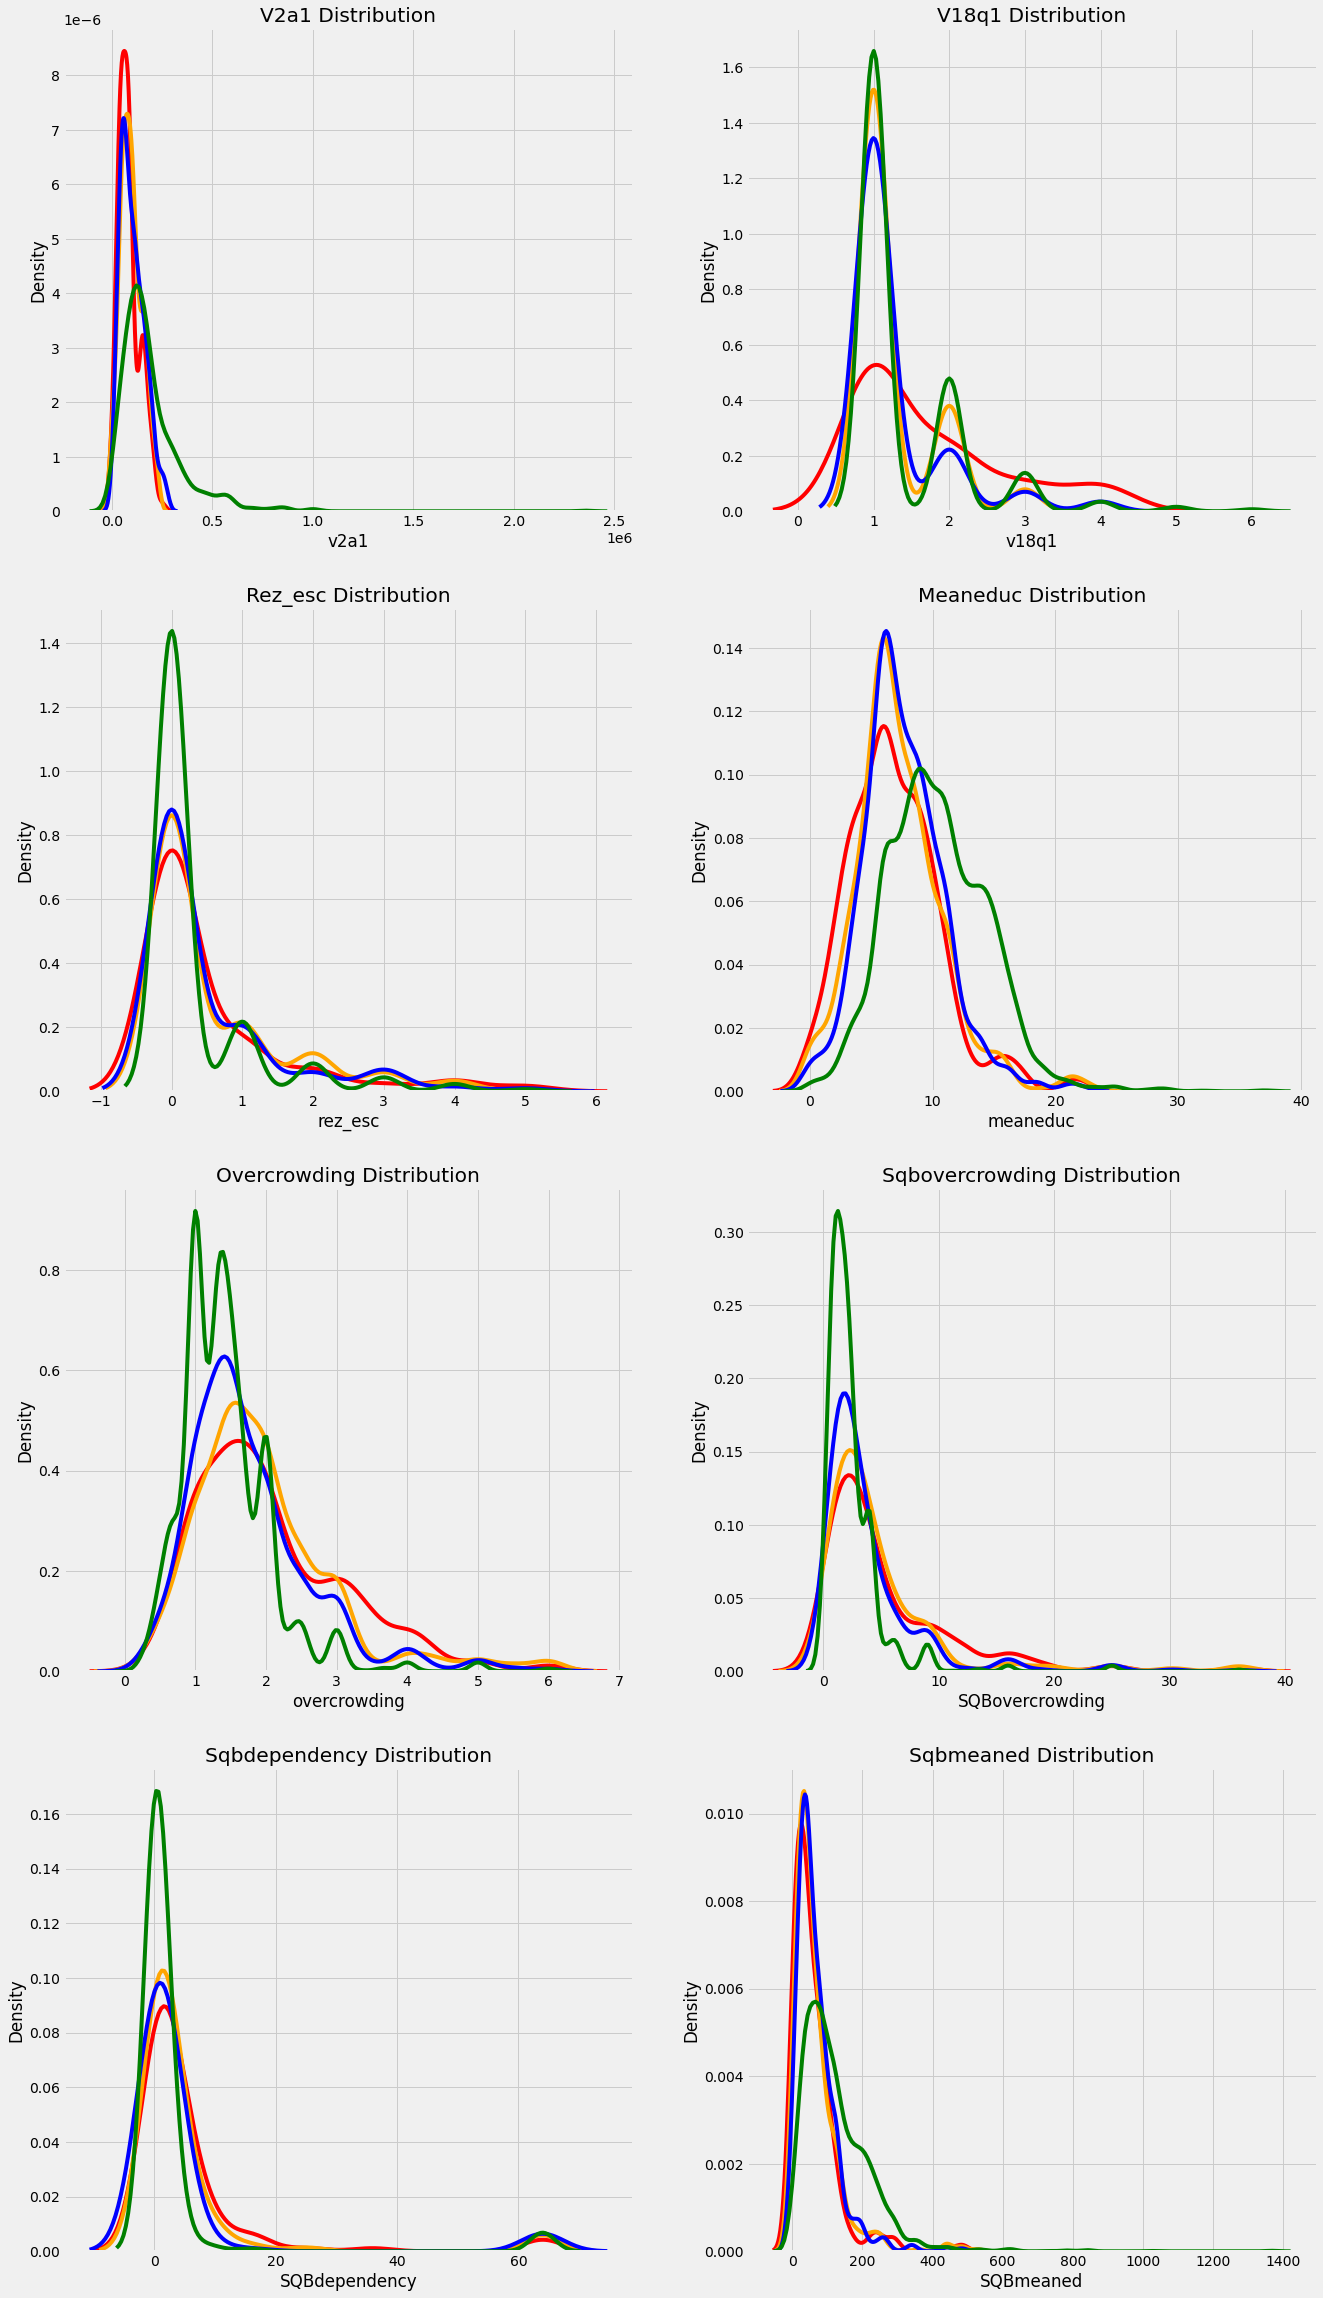

In [18]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2:'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot ezch poverty levle as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(),
                   ax = ax,
                   color = color,
                   label = poverty_mapping[poverty_level])
    
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    
plt.subplots_adjust(top = 2)